(generalised_filtering)=
# Generalised Bayesian Filtering of exponential family distributions

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/0.3-Generalised_filtering.ipynb)

In [1]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from scipy.stats import norm, t

from pyhgf.math import MultivariateNormal, Normal, gaussian_predictive_distribution
from pyhgf.model import Network
from pyhgf.utils import beliefs_propagation

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Hierarchical Gaussian filters can receive one-dimensional continuous and binary inputs by default, but they in practice be extended to a much broader class of distributions. Here, we use the approach described in {cite:p}`mathys:2020` to demonstrate that the Hierarchical Gaussian Filter can be generalized to any probability distribution that belongs to the [exponential family](https://en.wikipedia.org/wiki/Exponential_family). This is the sample principle that underpins the {ref}`categorical_hgf`, in which case the implied distribution is a Dirichlet distribution. However, by abstracting the specificity of each distribution away, we can implement probabilistic nodes that can flexibly filter any distribution from the exponential family, as an input node or as a state node, which greatly enlarges the range of possible models.

Generalised Bayesian filtering in this context requires first expressing the Bayesian update of an exponential family distribution as a simple update over hyperparameters. Exponential families of probability distributions are those which can be written in the form:

$$
p(x|\vartheta) = f_x(\vartheta) := h(x) exp(\eta(\vartheta) · t(x) − b(\vartheta))
$$

where:
- $x$ is a vector-valued observation
- $\vartheta$ is a parameter vector
- $h(x)$ is a normalization constant
- $\eta(\vartheta)$ is the natural parameter vector
- $t(x)$ is the sufficient statistic vector
- $b(\vartheta)$ is a scalar function

It has been shown in {cite:p}`mathys:2020` that, when chosing as prior:

$$
p(\vartheta|\xi, \nu) = g_{\xi, \nu}(\vartheta) := z(\xi, \nu) \exp (\nu(\eta(\vartheta)·\xi−b(\vartheta)))
$$

with the variable

$$
z(\xi, \nu) := (\int \exp(\nu(\eta(\vartheta) · \xi−b(\vartheta)))d\vartheta)^{−1}
$$

as normalization constant, then the posterior is a simple update of the hyperparameters in the form:

$$
\begin{align*}
& \nu \leftarrow \nu + 1 \\
& \xi \leftarrow \xi + \frac{1}{\nu + 1}(t(x)-\xi)
\end{align*}
$$

## Filtering the Sufficient Statistics of a Stationary Distribution

We start applying this update steps to the estimation of the parameters from a stationary normal distribution.

In [3]:
x = np.arange(-7, 7, 0.01)  # x axis
xi, nu = np.array([0, 1 / 8]), 1.0  # initial hyperparameters
xs = np.random.normal(5, 1 / 4, 1000)  # input observations

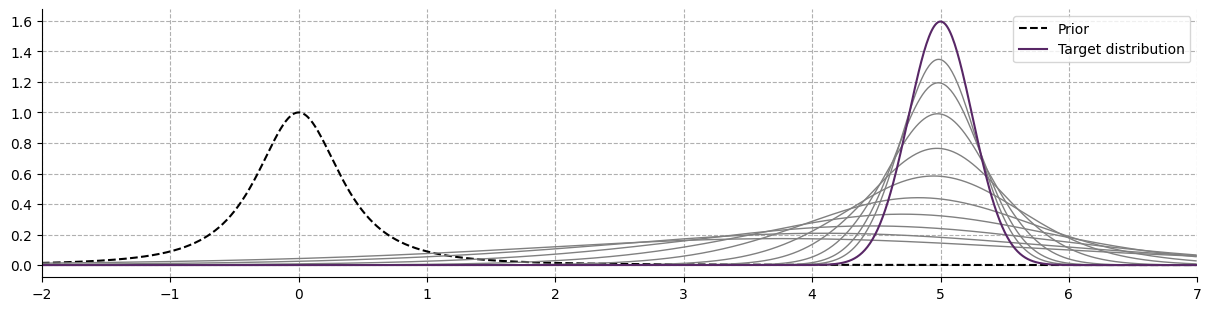

In [4]:
plt.figure(figsize=(12, 3))
plt.plot(
    x,
    gaussian_predictive_distribution(x, xi=xi, nu=nu),
    color="k",
    label="Prior",
    linestyle="--",
)
for i, x_i in enumerate(xs):
    xi = xi + (1 / (1 + nu)) * (
        Normal().sufficient_statistics_from_observations(x=x_i) - xi
    )
    nu += 1

    if i in [2, 4, 8, 16, 32, 64, 128, 256, 512, 999]:
        plt.plot(
            x,
            gaussian_predictive_distribution(x, xi=xi, nu=nu),
            color="grey",
            linewidth=1.0,
        )
plt.plot(
    x, norm.pdf(x, loc=5.0, scale=1 / 4), color="#582766", label="Target distribution"
)
plt.xlim(-2, 7)
plt.legend()
plt.grid(linestyle="--")
sns.despine()

The vizualisation of the predictive distribution over new observations require integrating the joint probability of the prior $g_{\xi, \nu}(\vartheta)$ and the posterior $f_x(\vartheta)$. In the case of a univariate normal, the *Gaussian-predictive* distribution is given by:

$$
\mathcal{NP}(x, \xi, \nu) := \sqrt{\frac{1}{\pi(\nu+1)(\xi_{x^2}-\xi_{x}^2)}}\frac{\Gamma(\frac{\nu+2}{2})}{\Gamma(\frac{\nu+1}{2})} \left( 1+\frac{(x-\xi_{x})^2}{(\nu+1)(\xi_{x^2}-\xi_x^2)} \right) ^{-\frac{\nu+2}{2}}
$$

When $\xi = 0, 1$, this corresponds to the Student's-t distribution with $\nu + 1$ degrees of freedom, as evidenced here:

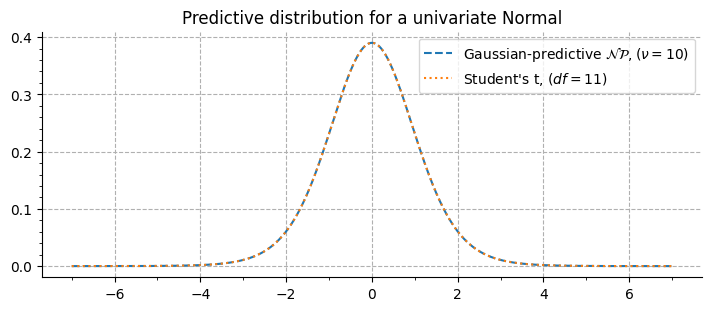

In [5]:
_, ax = plt.subplots(figsize=(7, 3))
ax.plot(
    x,
    gaussian_predictive_distribution(x, xi=np.array([0, 1]), nu=10),
    linestyle="--",
    label=r"Gaussian-predictive $\mathcal{NP}, (\nu = 10)$",
)

ax.plot(x, t.pdf(x, 11), linestyle=":", label=r"Student's t, $(df = 11)$")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.set_title("Predictive distribution for a univariate Normal")
ax.legend()
ax.grid(linestyle="--")
sns.despine()

## Filtering the Sufficient Statistics of a Non-Stationary Distribution
Real-world applications of Bayesian filtering imply non-stationary distributions, in which cases the agent cannot rely anymore on distant observation and has to weigh down their evidence proportional to their distance from the current time point. In the current framework, this suggests that $\nu$, the pseudo-count vector, cannot linearly increase with the number of new observations but has to be limited. The most straightforward way is then to fix it to some values.

### Using a fixed $\nu$: The Generalised Bayesian Filtering approach

This operation can be achieved using an exponential family state node, using the following parameters:
- Setting `kind="ef-state"`. We also set `learning="generalised-filtering"` to explicitly inform the node it should use the general filtering approach
- using a 1-dimensional Gaussian distribution by setting `dimension="normal"`
- using `nus=3.0`, this parameter will behave as the inverse of a learning rate, informing how much in the past we are looking to update the current sufficient statistics.
- setting `xis=np.array([0, 1 / 8])`, this is our starting point and first guess for the expected sufficient statistics.

Some of these steps were not necessary as this is the default behaviour for the toolbox, but we added them here for clarity.

In [6]:
generalised_filter = Network().add_nodes(
    kind="ef-state", distribution="normal", nus=3.0, xis=np.array([0, 1 / 8])
)

````{note} From sufficient statistics to distribution parameters and backwards
When using a 1-dimensional Gaussian distribution, Setting $\xi = [0, \frac{1}{8}]$ is equivalent to a mean $\mu = 0.0$ and a variance $\sigma^2 = \frac{1}{8}$. You can convert between distribution parameters and expected sufficient statistics using the distribution classes from PyHGF (when implemented):

```{code-cell} python
from pyhgf.math import Normal

# from an observation to sufficient statistics
Normal.sufficient_statistics_from_observations(x=1.5)
```
> Array([1.5 , 2.25], dtype=float32)
```{code-cell} python
# from distribution parameters to sufficient statistics
Normal.sufficient_statistics_from_parameters(mean=0.0, variance=4.0)
```
> Array([0., 4.], dtype=float32)
```{code-cell} python
# from sufficient statistics to distribution parameters
Normal.parameters_from_sufficient_statistics(xis=[0.0, 4.0])
```
> (0.0, 4.0)

````

The resulting network consists in a single node that encapsulate all computation and do not depends on other nodes. Nodes supporting exponential family distribution can therefore support inputs of various shapes whithout requiring multiple input nodes.

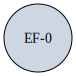

In [7]:
generalised_filter.plot_network()

In [8]:
generalised_filter.additional_parameters

{0: {'sufficient_stats_fn': <function pyhgf.math.Normal.sufficient_statistics_from_observations(x: float) -> jax.Array>}}

We then create a time series to filter and pass it to the network using different values for the parameter $\nu$, representing how much past values should influence the Bayesian update.

In [9]:
x = np.arange(0, 1000)  # time points

# create noisy input time series with switching means
y = np.random.normal(0, 1 / 8, 1000)
y[200:400] += 0.5
y[600:800] -= 0.5

In [10]:
means, variances = [], []
nus = [3, 9, 35]
for nu in nus:

    # set a new learning rate
    generalised_filter.attributes[0]["nus"] = nu

    # fit to new data and convert the sufficient statistics into distribution parameters
    mean, variance = Normal.parameters_from_sufficient_statistics(
        xis=generalised_filter.input_data(input_data=y).node_trajectories[0]["xis"].T
    )

    # save distribution parameters    
    means.append(mean)
    variances.append(variance)

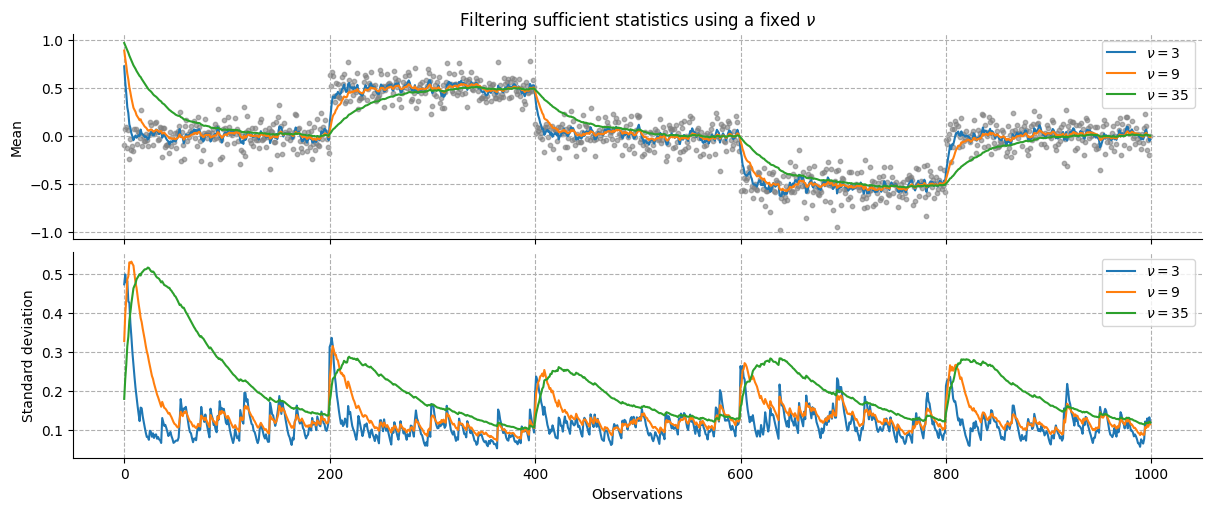

In [11]:
_, axs = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)
axs[0].scatter(x, y, color="grey", alpha=0.6, s=10)
for mean, nu in zip(means, nus):
    axs[0].plot(x, mean, label=rf"$\nu = {nu}$")
axs[0].grid(linestyle="--")
axs[0].set_title(r"Filtering sufficient statistics using a fixed $\nu$")
axs[0].set_ylabel("Mean")
axs[0].legend()

for variance, nu in zip(variances, nus):
    axs[1].plot(x, jnp.sqrt(variance), label=rf"$\nu = {nu}$")
axs[1].grid(linestyle="--")
axs[1].set_xlabel("Observations")
axs[1].set_ylabel("Standard deviation")
axs[1].legend()

sns.despine()

We can see that larger values for $\nu$ correspond to a lower learning rate, and therefore smoother transition between states.

### Using a dynamically adapted $\nu$ through a collection of Hierarchical Gaussian Filters

Limiting the number of past observations weighting in the predictive distribution comes with the difficult question of how to choose the correct value for such a parameter. Here, one solution to handle this is to let this parameter vary across time as a function of the volatility of the observations. Large unexpected variations should increase the learning rate, while limited, expected variations should increase the posterior precision. Interestingly, this is the kind of dynamic adaptation that reinforcement learning models are implementing, including the Hierarchical Gaussian Filter in this category. Here, we can derive the implied $\nu$ from a ratio of prediction and observation differentials such as:

$$
\nu \leftarrow \frac{\delta}{\Delta}
$$

with $\delta$ the prediction error at time $k$ and $\Delta$ the differential of expectations (before and after observing the new value).

#### Univariate normal distribution

In [12]:
univariate_hgf =  Network().add_nodes(kind="ef-state", learning="hgf-2")
univariate_hgf.attributes[1]["precision"] = 100.0
univariate_hgf.attributes[3]["precision"] = 100.0

univariate_hgf.attributes[2]["tonic_volatility"] = -6.0
univariate_hgf.attributes[5]["tonic_volatility"] = -6.0

univariate_hgf.attributes[3]["tonic_volatility"] = -2.0
univariate_hgf.attributes[6]["tonic_volatility"] = -2.0

univariate_hgf.attributes[6]["mean"] = -6.0

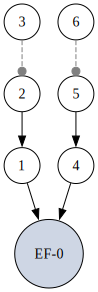

In [13]:
univariate_hgf.plot_network()

In [15]:
univariate_hgf.input_data(input_data=y);

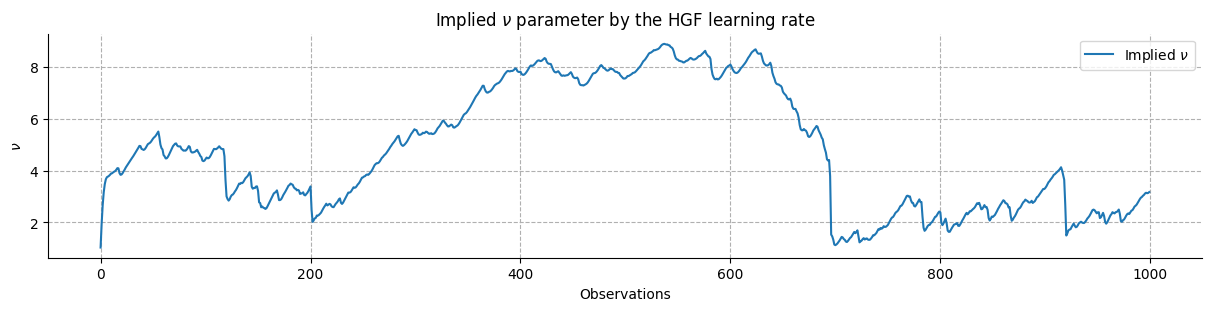

In [18]:
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(x, nus[:,0], label=rf"Implied $\nu$")
ax.grid(linestyle="--")
ax.set_title(r"Implied $\nu$ parameter by the HGF learning rate")
ax.set_ylabel(r"$\nu$")
ax.set_xlabel("Observations")
ax.legend()
sns.despine()

#### Bivariate normal distribution

In [24]:
bivariate_hgf = Network().add_nodes(
    kind="ef-state", 
    learning="hgf-2", 
    distribution="multivariate-normal", 
    dimension=2
)

bivariate_hgf.attributes[2]["tonic_volatility"] = -6.0
bivariate_hgf.attributes[5]["tonic_volatility"] = -6.0
bivariate_hgf.attributes[8]["tonic_volatility"] = -6.0
bivariate_hgf.attributes[11]["tonic_volatility"] = -6.0
bivariate_hgf.attributes[14]["tonic_volatility"] = -6.0

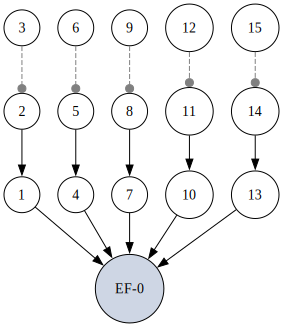

In [25]:
bivariate_hgf.plot_network()

In [19]:
# simulate an ordered spiral data set
N = 1000
theta = np.sort(np.sqrt(np.random.rand(N)) * 5 * np.pi)
r_a = -2 * theta - np.pi
input_data = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
input_data = input_data + np.random.randn(N, 2) * 2

In [20]:
# get the sufficient statistics from the first observation to parametrize the model
sufficient_statistics = jnp.apply_along_axis(
    MultivariateNormal().sufficient_statistics, 1, input_data
)

AttributeError: 'MultivariateNormal' object has no attribute 'sufficient_statistics'

Filtering the sufficient statistics of a two dimensional multivariate normal distribution requires tracking the values of 5 parameters in paralell. Our model therefore consist in 5 independent two-level continuous HGF.

In [ ]:
bivariate_hgf = Network().add_nodes(precision=0.1, n_nodes=5)

for i in range(5):
    bivariate_hgf.add_nodes(
        value_children=i,
        node_parameters={
            "tonic_volatility": -6.0,
            "mean": sufficient_statistics[0][i],
        },
    )

for i in range(5):
    bivariate_hgf.add_nodes(
        volatility_children=[i + 5],
        node_parameters={"mean": 10.0, "tonic_volatility": -2},
    )
bivariate_hgf.plot_network()

In [17]:
# run this code to create the animation

# fig, ax = plt.subplots(figsize=(5, 5))
# scat = ax.scatter(
#     input_data[0, 0],
#     input_data[0, 1],
#     edgecolor="k",
#     alpha=0.4,
#     s=10
# )
# scat2 = ax.scatter(
#     means[0, 1],
#     means[0, 0],
#     edgecolor="#c44e52",
#     s=25
# )
# plot = ax.plot(
#     means[0, 1],
#     means[0, 0],
#     color="#c44e52",
#     linestyle="--",
#     label="Belief trajectory"
# )[0]
# ax.grid(linestyle="--")
# ax.set(
#     xlim=[-35, 35],
#     ylim=[-35, 35],
#     xlabel=r"$x_1$",
#     ylabel=r"$x_2$",
#     title=r"Filtering a bivariate stochastic process",
# )
# plt.tight_layout()
#
#
# def update(frame):
#     # update the scatter plot
#     data = np.stack([input_data[:frame, 0], input_data[:frame, 1]]).T
#     scat.set_offsets(data)
#
#     data2 = np.stack([means[frame, 0], means[frame, 1]]).T
#     scat2.set_offsets(data2)
#
#     # update the belief trajectory
#     plot.set_ydata(means[:frame, 1])
#     plot.set_xdata(means[:frame, 0])
#     return scat, scat2, plot
#
# ani = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=30)
# ani.save("anim.gif")

![multivariate_hgf](../images/multivariate_hgf.gif)

```{note}
The animation above displays the mean tracking of a bivariate normal distribution. This is equivalent to tracking the mean of the x and y axis using two separate HGFs. However, the generalized filtering process does more than that under the hood by tracking the whole sufficient statistic vector, which incorporates information about the covariance of the implied multivariate distribution. The full visualization of this distribution requires derivating the posterior predictive distribution of the multivariate normal, as parametrized by the vectors $\nu$ and $\xi$.
```

# System configuration

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Jan 10 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.31.0

pyhgf : 0.2.1.post4.dev0+d49aafe9
jax   : 0.4.31
jaxlib: 0.4.31

matplotlib: 3.10.0
pyhgf     : 0.2.1.post4.dev0+d49aafe9
seaborn   : 0.13.2
numpy     : 1.26.0
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
IPython   : 8.31.0
jax       : 0.4.31

Watermark: 2.5.0

